In [3]:
import pandas as pd
import os
import datetime
to_datetime = lambda d: pd.to_datetime(d, format='%d/%m/%Y')

In [25]:
fiis_names = [line.rstrip('\n') for line in open('../cotacoes/carteiras/IFIX.sa.txt')]
fiis_dataFrame = pd.DataFrame()
dir = "../cotacoes/dados/b3/cotacoes_diarias/"

for fn in fiis_names:
    file_name = dir + fn + '.csv'
    try:
        fiis_dataFrame = fiis_dataFrame.merge(pd.read_csv(file_name, converters={'date': to_datetime}).set_index('date').add_suffix('_'+fn), how='outer', left_index=True, right_index=True)
    except:
        print(file_name + ' not found!')
    
fiis_dataFrame.tail()

../cotacoes/dados/b3/cotacoes_diarias/ABCP11.sa.csv not found!


,open_BPFF11.sa,high_BPFF11.sa,low_BPFF11.sa,close_BPFF11.sa,neg_BPFF11.sa,vol_BPFF11.sa,open_ALZR11.sa,high_ALZR11.sa,low_ALZR11.sa,close_ALZR11.sa,...,low_XPCM11.sa,close_XPCM11.sa,neg_XPCM11.sa,vol_XPCM11.sa,open_XPML11.sa,high_XPML11.sa,low_XPML11.sa,close_XPML11.sa,neg_XPML11.sa,vol_XPML11.sa
date,,,,,,,,,,,,,,,,,,,,,
2019-08-22,104.99,105.00,103.61,105.00,174.0,27388747.0,105.70,105.89,105.30,105.60,...,56.21,56.27,256.0,28983493.0,111.25,111.69,111.11,111.69,1328.0,361339304.0
2019-08-23,104.98,104.98,103.58,103.58,191.0,37688776.0,105.59,105.59,104.55,105.00,...,56.05,56.61,408.0,45688163.0,111.69,111.79,110.13,110.85,1967.0,506810955.0
2019-08-26,103.60,105.00,102.84,102.84,380.0,87634430.0,105.01,105.02,104.10,104.49,...,56.20,56.25,339.0,50694398.0,110.90,111.45,110.12,110.94,1744.0,370917899.0
2019-08-27,103.00,103.99,102.13,103.16,140.0,18323894.0,104.70,105.47,103.55,104.93,...,56.10,56.10,336.0,59351092.0,110.93,110.93,110.12,110.75,1424.0,454071646.0
2019-08-28,103.20,104.25,102.14,103.75,407.0,96659814.0,104.80,105.69,104.30,104.60,...,56.20,56.89,346.0,62076364.0,110.60,111.45,110.02,111.45,1090.0,356731930.0


In [79]:
start = to_datetime('1/08/2017')
fiis = fiis_dataFrame[fiis_dataFrame.index >= start]
fiis = fiis.dropna(axis=1, how='any')
to_drop = ['close_FFCI11.sa']
fiis = fiis.drop(to_drop, axis=1)

#fiis.plot(figsize=(15,6))
#fiis.tail()

In [80]:
fiis_closing_key = []

for key in fiis.keys():
    if(key.startswith('close')):
        fiis_closing_key.append(key)
        
#fiis_closing_key

#'g' in df.index

In [83]:
def monthdelta(date, delta):
    m, y = (date.month+delta) % 12, date.year + ((date.month)+delta-1) // 12
    if not m: m = 12
    d = min(date.day, [31,
        29 if y%4==0 and not y%400==0 else 28,31,30,31,30,31,31,30,31,30,31][m-1])
    return date.replace(day=d,month=m, year=y)


fiis_per_month = 20
buy_size = 2000
balance = buy_size * fiis_per_month
wallet = [] # fiis_per_month x 2
# wallet[x][0] = asset name
# wallet[x][1] = asset qty

skip = datetime.timedelta(days=1)

variation = []
fiis_to_buy = []

past = start
current = monthdelta(past, 1)
while current < fiis.index[-1]:
    while not current in fiis.index and current < fiis.index[-1]:
        current = current + skip
       
    current_data = fiis.loc[current]
    past_data = fiis.loc[past]
    
    # sells old assets
    while len(wallet):
        to_sell = wallet.pop()
        balance += current_data[to_sell[0]] * to_sell[1]
        #print(current_data[to_sell[0]])
        #print(to_sell[0])
        
      
    
    # finds new assets to buy
    # calculates variations
    variation = []
    for f in fiis_closing_key:
        variation.append((current_data[f] - past_data[f])/past_data[f])
        
    # picks maximum drops
    for fpm in range(fiis_per_month):
        index = variation.index(min(variation))
        variation[index] = 10000 # big value for elimination sake
        to_buy = fiis_closing_key[index]
        fii_price = current_data[to_buy]
        
        # calculates qty
        qty = round(buy_size/fii_price)
        
        # buys new assets
        wallet.append([to_buy, qty])
        balance -= fii_price * qty
     
    print(str(current.strftime('%d/%m/%Y')) + ': R$ ' + str(round(balance, 2)))
    print(wallet)
    print('-----')
    past = current
    current = monthdelta(current, 1)

01/09/2017: R$ -342.25
[['close_EDGA11.sa', 47.0], ['close_RBRD11.sa', 25.0], ['close_BCRI11.sa', 19.0], ['close_FIIP11B.sa', 11.0], ['close_JSRE11.sa', 21.0], ['close_JRDM11.sa', 24.0], ['close_HTMX11.sa', 18.0], ['close_KNCR11.sa', 19.0], ['close_MXRF11.sa', 214.0], ['close_TBOF11.sa', 29.0], ['close_CTXT11.sa', 469.0], ['close_KNRI11.sa', 13.0], ['close_SAAG11.sa', 16.0], ['close_CPTS11B.sa', 20.0], ['close_GGRC11.sa', 17.0], ['close_CEOC11.sa', 24.0], ['close_FAED11.sa', 10.0], ['close_KNIP11.sa', 19.0], ['close_BBRC11.sa', 15.0], ['close_CNES11.sa', 20.0]]
-----
02/10/2017: R$ 632.9
[['close_ALMI11.sa', 1.0], ['close_FAED11.sa', 10.0], ['close_JSRE11.sa', 21.0], ['close_RBRD11.sa', 25.0], ['close_SDIL11.sa', 22.0], ['close_BCRI11.sa', 19.0], ['close_BBFI11B.sa', 1.0], ['close_KNCR11.sa', 19.0], ['close_SPTW11.sa', 28.0], ['close_FEXC11.sa', 21.0], ['close_CPTS11B.sa', 20.0], ['close_KNIP11.sa', 19.0], ['close_BPFF11.sa', 21.0], ['close_MXRF11.sa', 211.0], ['close_NSLU11.sa', 8.0],

In [76]:
current = start
current = start + datetime.timedelta(days=400)
print(current)
print(fiis.index[-1])
print(current < fiis.index[-1])

2019-10-02 00:00:00
2019-08-28 00:00:00
False


In [228]:

fiis_dataFrameTest = pd.DataFrame()

test2 = pd.read_csv(dir + 'ALUP11.sa.csv', converters={'date': to_datetime}).set_index('date')
test2 = test2.add_prefix('oi')
print(test2.tail())

fiis_dataFrameTest = fiis_dataFrameTest.merge( test2, how='outer', left_index=True, right_index=True, suffixes=('', '2'))

print(fiis_dataFrameTest.tail())


            oiopen  oihigh  oilow  oiclose  oineg       oivol
date                                                         
2019-08-22   25.61   25.80  25.47    25.80   1868   787540300
2019-08-23   25.73   25.73  25.14    25.40   2088   955703900
2019-08-26   25.79   25.79  24.86    25.10   2317  1025724100
2019-08-27   25.20   25.49  24.76    24.99   2080  1261621400
2019-08-28   24.94   25.50  24.78    25.22   2518  1139040400
            oiopen  oihigh  oilow  oiclose  oineg       oivol
date                                                         
2019-08-22   25.61   25.80  25.47    25.80   1868   787540300
2019-08-23   25.73   25.73  25.14    25.40   2088   955703900
2019-08-26   25.79   25.79  24.86    25.10   2317  1025724100
2019-08-27   25.20   25.49  24.76    24.99   2080  1261621400
2019-08-28   24.94   25.50  24.78    25.22   2518  1139040400


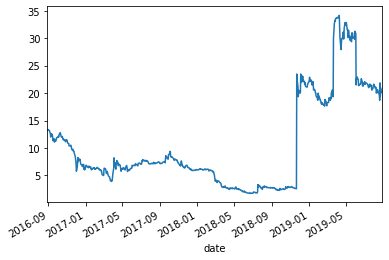

In [233]:
#[['close_RNEW11', 385.0], ['close_KLBN11', 56.0], ['close_SULA11', 39.0]]
fiis['close_RNEW11'].plot()

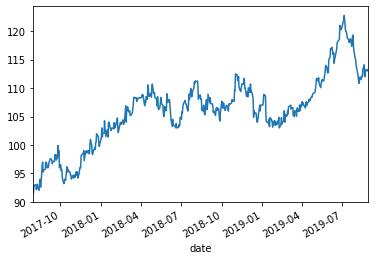

In [88]:
#[['close_FIGS11.sa', 31.0], ['close_HTMX11.sa', 14.0], ['close_RNGO11.sa', 24.0], ['close_BBRC11.sa', 14.0], ['close_FEXC11.sa', 19.0], ['close_XPCM11.sa', 21.0], ['close_FIIP11B.sa', 10.0], ['close_KNCR11.sa', 19.0], ['close_KNIP11.sa', 18.0], ['close_CPTS11B.sa', 20.0], ['close_BBPO11.sa', 14.0], ['close_JRDM11.sa', 28.0], ['close_CBOP11.sa', 27.0], ['close_SAAG11.sa', 16.0], ['close_KNRI11.sa', 13.0], ['close_NSLU11.sa', 9.0], ['close_CTXT11.sa', 478.0], ['close_BRCR11.sa', 19.0], ['close_BCRI11.sa', 18.0], ['close_CNES11.sa', 25.0]]
fiis['close_FEXC11.sa'].plot()